In [63]:

"""Configuration settings for the weather analysis system"""
API_KEY = '9c909306e9c168ab67cc723e8605da75'
BASE_URL = 'https://api.openweathermap.org/data/2.5/'
DB_NAME = 'weather_data.db'
MODEL_PATH = 'models/weather_model.pkl'

CITIES = [
    'London', 'New York', 'Tokyo', 'Paris', 'Sydney',
    'Mumbai', 'Dubai', 'Singapore', 'Toronto', 'Berlin',
    'Moscow', 'Rome', 'Madrid', 'Seoul', 'Bangkok'
]

In [64]:
import sqlite3
import pandas as pd
from datetime import datetime, timedelta
import logging
import os

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

def initialize_database():
    """Create database and populate with initial data if empty"""
    try:
        logger.info(f"Initializing database: {DB_NAME}")
        conn = sqlite3.connect(DB_NAME)
        cursor = conn.cursor()

        # Create table
        cursor.execute('''
            CREATE TABLE IF NOT EXISTS weather_data (
                id INTEGER PRIMARY KEY AUTOINCREMENT,
                city TEXT,
                date TEXT,
                current_temp REAL,
                feels_like REAL,
                temp_min REAL,
                temp_max REAL,
                humidity INTEGER,
                pressure INTEGER,
                wind_speed REAL,
                wind_dir INTEGER,
                description TEXT
            )
        ''')

        # Verify table creation
        cursor.execute("SELECT name FROM sqlite_master WHERE type='table' AND name='weather_data'")
        if not cursor.fetchone():
            raise Exception("Failed to create weather_data table")

        # Check if database is empty
        cursor.execute("SELECT COUNT(*) FROM weather_data")
        count = cursor.fetchone()[0]
        logger.info(f"Current record count: {count}")

        if count == 0:
            logger.info("Database empty, initializing with historical data...")
            # Fetch current weather for all cities and backdate it
            for city in CITIES:
                logger.info(f"Processing historical data for {city}")
                weather_data = get_current_weather(city)
                if weather_data:
                    # Create 90 days of historical data
                    for days_ago in range(90, 0, -1):
                        historical_date = (datetime.now() - timedelta(days=days_ago)).strftime('%Y-%m-%d %H:%M:%S')
                        # Add some random variation to the current values
                        temp_variation = random.uniform(-5, 5)
                        humidity_variation = random.uniform(-10, 10)
                        pressure_variation = random.uniform(-10, 10)

                        try:
                            cursor.execute('''
                                INSERT INTO weather_data
                                (city, date, current_temp, feels_like, temp_min, temp_max,
                                 humidity, pressure, wind_speed, wind_dir, description)
                                VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
                            ''', (
                                weather_data['city'],
                                historical_date,
                                weather_data['current_temp'] + temp_variation,
                                weather_data['feels_like'] + temp_variation,
                                weather_data['temp_min'] + temp_variation,
                                weather_data['temp_max'] + temp_variation,
                                min(100, max(0, weather_data['humidity'] + humidity_variation)),
                                weather_data['pressure'] + pressure_variation,
                                weather_data['wind_speed'],
                                weather_data['wind_dir'],
                                weather_data['description']
                            ))

                            if days_ago % 30 == 0:  # Log progress every 30 days
                                logger.info(f"Added historical data for {city}: {historical_date}")

                        except sqlite3.Error as e:
                            logger.error(f"Error inserting data for {city}: {e}")
                            continue

                    # Verify data was inserted for this city
                    cursor.execute("SELECT COUNT(*) FROM weather_data WHERE city = ?", (city,))
                    city_count = cursor.fetchone()[0]
                    logger.info(f"Added {city_count} records for {city}")

            conn.commit()

            # Verify final data count
            cursor.execute("SELECT COUNT(*) FROM weather_data")
            final_count = cursor.fetchone()[0]
            logger.info(f"Historical data initialization complete. Total records: {final_count}")

    except Exception as e:
        logger.error(f"Database initialization error: {e}")
        raise
    finally:
        conn.close()

def store_weather_data(weather_data):
    """Store weather data in database"""
    conn = sqlite3.connect(DB_NAME)
    cursor = conn.cursor()

    current_date = datetime.now().strftime('%Y-%m-%d %H:%M:%S')

    try:
        cursor.execute('''
            INSERT INTO weather_data
            (city, date, current_temp, feels_like, temp_min, temp_max,
             humidity, pressure, wind_speed, wind_dir, description)
            VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
        ''', (
            weather_data['city'], current_date, weather_data['current_temp'],
            weather_data['feels_like'], weather_data['temp_min'], weather_data['temp_max'],
            weather_data['humidity'], weather_data['pressure'], weather_data['wind_speed'],
            weather_data['wind_dir'], weather_data['description']
        ))
        conn.commit()
        print(f"Weather data stored for {weather_data['city']}.")
    except Exception as e:
        print(f"Error storing weather data: {e}")
    finally:
        conn.close()

def get_historical_data(days=90):
    """Retrieve historical weather data"""
    conn = sqlite3.connect(DB_NAME)

    # Convert dates to strings in the correct format
    end_date = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    start_date = (datetime.now() - timedelta(days=days)).strftime('%Y-%m-%d %H:%M:%S')

    query = '''
        SELECT * FROM weather_data
        WHERE date BETWEEN ? AND ?
        ORDER BY date
    '''

    try:
        df = pd.read_sql_query(query, conn, params=(start_date, end_date))

        if df.empty:
            print("Warning: No historical data found in the specified date range")
        else:
            # Convert date column to datetime
            df['date'] = pd.to_datetime(df['date'])

        return df

    except Exception as e:
        print(f"Error retrieving historical data: {e}")
        return pd.DataFrame()
    finally:
        conn.close()



In [65]:
def diagnose_database():
    """Diagnose database state and content"""
    try:
        conn = sqlite3.connect(DB_NAME)
        cursor = conn.cursor()

        # Check if database file exists
        print(f"\nDatabase file exists: {os.path.exists(DB_NAME)}")

        # Check table existence
        cursor.execute("SELECT name FROM sqlite_master WHERE type='table' AND name='weather_data'")
        table_exists = cursor.fetchone() is not None
        print(f"Weather data table exists: {table_exists}")

        if table_exists:
            # Check total record count
            cursor.execute("SELECT COUNT(*) FROM weather_data")
            total_records = cursor.fetchone()[0]
            print(f"Total records in database: {total_records}")

            # Check records per city
            cursor.execute("""
                SELECT city, COUNT(*) as count,
                       MIN(date) as earliest_date,
                       MAX(date) as latest_date
                FROM weather_data
                GROUP BY city
            """)
            city_stats = cursor.fetchall()

            if city_stats:
                print("\nRecords per city:")
                for city, count, earliest, latest in city_stats:
                    print(f"{city}: {count} records ({earliest} to {latest})")
            else:
                print("No city records found")

            # Check for any NULL values
            cursor.execute("""
                SELECT COUNT(*) FROM weather_data
                WHERE city IS NULL
                   OR date IS NULL
                   OR current_temp IS NULL
            """)
            null_count = cursor.fetchone()[0]
            print(f"\nRecords with NULL values: {null_count}")

            # Sample most recent records
            cursor.execute("""
                SELECT city, date, current_temp, humidity, pressure
                FROM weather_data
                ORDER BY date DESC
                LIMIT 5
            """)
            recent_records = cursor.fetchall()
            if recent_records:
                print("\nMost recent records:")
                for record in recent_records:
                    print(f"City: {record[0]}, Date: {record[1]}, Temp: {record[2]}°C, Humidity: {record[3]}%, Pressure: {record[4]} hPa")

    except sqlite3.Error as e:
        print(f"Database error: {e}")
    finally:
        conn.close()

def verify_data_insertion():
    """Verify that new data is being properly inserted"""
    try:
        # Get current weather for a test city
        test_city = CITIES[0]
        weather_data = get_current_weather(test_city)

        if weather_data:
            print(f"\nTesting data insertion for {test_city}")

            # Store the data
            store_weather_data(weather_data)

            # Verify the insertion
            conn = sqlite3.connect(DB_NAME)
            cursor = conn.cursor()

            cursor.execute("""
                SELECT * FROM weather_data
                WHERE city = ?
                ORDER BY date DESC
                LIMIT 1
            """, (test_city,))

            record = cursor.fetchone()
            if record:
                print("Data successfully inserted:")
                print(f"City: {record[1]}")
                print(f"Date: {record[2]}")
                print(f"Temperature: {record[3]}°C")
                print(f"Humidity: {record[7]}%")
                return True
            else:
                print("Failed to find inserted record")
                return False

    except Exception as e:
        print(f"Verification error: {e}")
        return False
    finally:
        conn.close()

In [66]:
import requests

def get_current_weather(city):
    """Fetch current weather data from API"""
    try:
        url = f"{BASE_URL}weather?q={city}&appid={API_KEY}&units=metric"
        response = requests.get(url)
        response.raise_for_status()
        data = response.json()

        return {
            'city': data['name'],
            'current_temp': round(data['main']['temp'], 2),
            'feels_like': round(data['main']['feels_like'], 2),
            'temp_min': round(data['main']['temp_min'], 2),
            'temp_max': round(data['main']['temp_max'], 2),
            'humidity': data['main']['humidity'],
            'pressure': data['main']['pressure'],
            'wind_speed': data['wind'].get('speed', 0),
            'wind_dir': data['wind'].get('deg', 0),
            'description': data['weather'][0]['description']
        }
    except requests.exceptions.RequestException as e:
        print(f"Error fetching weather data for {city}: {e}")
        return None

In [67]:
import matplotlib.pyplot as plt
import numpy as np

def plot_weather_dashboard(data, city):
    """Create comprehensive weather dashboard with built-in matplotlib style"""
    plt.style.use('default')  # Use default style instead of seaborn
    fig = plt.figure(figsize=(15, 10))
    fig.suptitle(f'Weather Dashboard - {city}', size=16)

    # Temperature Variation
    ax1 = plt.subplot(2, 2, 1)
    data['date'] = pd.to_datetime(data['date'])
    ax1.fill_between(data['date'], data['temp_min'], data['temp_max'],
                    alpha=0.3, color='lightblue')
    ax1.plot(data['date'], data['current_temp'], color='red', label='Current')
    ax1.set_title('Temperature Range')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Temperature (°C)')
    ax1.legend()
    ax1.tick_params(axis='x', rotation=45)
    ax1.grid(True, alpha=0.3)

    # Humidity vs Temperature
    ax2 = plt.subplot(2, 2, 2)
    scatter = ax2.scatter(data['current_temp'], data['humidity'],
                         c=data['pressure'], cmap='viridis')
    ax2.set_title('Humidity vs Temperature')
    ax2.set_xlabel('Temperature (°C)')
    ax2.set_ylabel('Humidity (%)')
    ax2.grid(True, alpha=0.3)
    plt.colorbar(scatter, label='Pressure (hPa)')

    # Wind Rose
    ax3 = plt.subplot(2, 2, 3, projection='polar')
    wind_dirs = data['wind_dir']
    wind_speeds = data['wind_speed']
    ax3.scatter(np.radians(wind_dirs), wind_speeds, alpha=0.5)
    ax3.set_title('Wind Direction and Speed')
    ax3.set_theta_direction(-1)
    ax3.set_theta_zero_location('N')
    ax3.grid(True)

    # Pressure Trends
    ax4 = plt.subplot(2, 2, 4)
    ax4.plot(data['date'], data['pressure'], color='purple')
    ax4.set_title('Pressure Trends')
    ax4.set_xlabel('Date')
    ax4.set_ylabel('Pressure (hPa)')
    ax4.tick_params(axis='x', rotation=45)
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def plot_city_comparison(data):
    """Plot weather comparison across cities with built-in matplotlib style"""
    plt.style.use('default')  # Use default style instead of seaborn

    city_stats = data.groupby('city').agg({
        'current_temp': 'mean',
        'humidity': 'mean',
        'pressure': 'mean',
        'wind_speed': 'mean'
    }).reset_index()

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Weather Comparison Across Cities', size=16)

    # Temperature comparison
    axes[0,0].bar(city_stats['city'], city_stats['current_temp'])
    axes[0,0].set_title('Average Temperature')
    axes[0,0].tick_params(axis='x', rotation=45)
    axes[0,0].set_ylabel('Temperature (°C)')
    axes[0,0].grid(True, alpha=0.3)

    # Humidity comparison
    axes[0,1].bar(city_stats['city'], city_stats['humidity'])
    axes[0,1].set_title('Average Humidity')
    axes[0,1].tick_params(axis='x', rotation=45)
    axes[0,1].set_ylabel('Humidity (%)')
    axes[0,1].grid(True, alpha=0.3)

    # Pressure comparison
    axes[1,0].bar(city_stats['city'], city_stats['pressure'])
    axes[1,0].set_title('Average Pressure')
    axes[1,0].tick_params(axis='x', rotation=45)
    axes[1,0].set_ylabel('Pressure (hPa)')
    axes[1,0].grid(True, alpha=0.3)

    # Wind speed comparison
    axes[1,1].bar(city_stats['city'], city_stats['wind_speed'])
    axes[1,1].set_title('Average Wind Speed')
    axes[1,1].tick_params(axis='x', rotation=45)
    axes[1,1].set_ylabel('Wind Speed (m/s)')
    axes[1,1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

In [68]:
import pickle
import os
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
def train_model(data):
    """Train and save weather prediction model with improved features"""
    if len(data) < 10:
        print(f"Not enough data to train model. Current dataset size: {len(data)}")
        return None

    # Create more sophisticated features
    X = pd.DataFrame({
        'temp': data['current_temp'],
        'humidity': data['humidity'],
        'pressure': data['pressure'],
        'wind_speed': data['wind_speed'],
        'temp_range': data['temp_max'] - data['temp_min'],
        'pressure_change': data['pressure'].diff().fillna(0),
        'temp_change': data['current_temp'].diff().fillna(0)
    }).fillna(0)

    # More sophisticated rain prediction rule
    y = ((data['humidity'] > 70) &
         ((data['pressure'] < 1013) | (data['description'].str.contains('rain|drizzle|shower')))).astype(int)

    # Split data for validation
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = GradientBoostingClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=3,
        random_state=42
    )
    model.fit(X_train, y_train)

    # Print model performance metrics
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    print(f"Model Training Score: {train_score:.2f}")
    print(f"Model Testing Score: {test_score:.2f}")

    os.makedirs(os.path.dirname(MODEL_PATH), exist_ok=True)
    with open(MODEL_PATH, 'wb') as f:
        pickle.dump(model, f)

    print("Model training complete.")
    return model


def load_model():
    """Load trained model if it exists"""
    if os.path.exists(MODEL_PATH):
        with open(MODEL_PATH, 'rb') as f:
            return pickle.load(f)
    return None


In [69]:
def main():
    """Main application function with improved error handling"""
    try:
        # Initialize database
        initialize_database()

        print("\nRunning database diagnostics...")
        diagnose_database()

        # Verify data insertion
        print("\nVerifying data insertion...")
        verify_data_insertion()

        # Fetch and store weather data for all cities
        print("Fetching weather data for all cities...")
        for city in CITIES:
            weather_data = get_current_weather(city)
            if weather_data:
                store_weather_data(weather_data)

        # Get user input
        city = input("\nEnter city name to analyze: ")
        current_weather = get_current_weather(city)

        if current_weather is None:
            print("Unable to fetch weather data. Please try again.")
            return

        # Load or train model
        model = load_model()

        # Get historical data
        print("\nRetrieving historical weather data...")
        historical_data = get_historical_data()

        if historical_data.empty:
            print("Warning: No historical data available for visualization")
        else:
            print(f"Retrieved {len(historical_data)} historical records")

        if model is None and not historical_data.empty:
            print("Training new weather prediction model...")
            model = train_model(historical_data)

        # Display current weather
        print(f"\nWeather Report for {city}")
        print("=" * 50)
        print(f"Current Temperature: {current_weather['current_temp']}\u00b0C")
        print(f"Feels Like: {current_weather['feels_like']}\u00b0C")
        print(f"Min/Max Temperature: {current_weather['temp_min']}\u00b0C / {current_weather['temp_max']}\u00b0C")
        print(f"Humidity: {current_weather['humidity']}%")
        print(f"Pressure: {current_weather['pressure']} hPa")
        print(f"Wind Speed: {current_weather['wind_speed']} m/s")
        print(f"Current Conditions: {current_weather['description']}")

        if model:
            features = pd.DataFrame({
                'temp': [current_weather['current_temp']],
                'humidity': [current_weather['humidity']],
                'pressure': [current_weather['pressure']],
                'wind_speed': [current_weather['wind_speed']],
                'temp_range': [current_weather['temp_max'] - current_weather['temp_min']],
                'pressure_change': [0],  # Initial value for new prediction
                'temp_change': [0]  # Initial value for new prediction
            })

            rain_probability = model.predict_proba(features)[0][1]
            rain_prediction = "Yes" if rain_probability > 0.5 else "No"
            print(f"\nRain Prediction for Tomorrow: {rain_prediction}")
            print(f"Rain Probability: {rain_probability:.2%}")
        else:
            print("\nNo weather prediction model available")

        # Generate visualizations if we have historical data
        if not historical_data.empty:
            print("\nGenerating weather visualizations...")
            city_data = historical_data[historical_data['city'] == city]
            if not city_data.empty:
                plot_weather_dashboard(city_data, city)
                plot_city_comparison(historical_data)
                print("Visualization complete!")
            else:
                print(f"No historical data available for {city}")

    except Exception as e:
        logger.error(f"Application error: {e}")
        print(f"An error occurred: {e}")


Running database diagnostics...

Database file exists: True
Weather data table exists: True
Total records in database: 167

Records per city:
Bangkok: 11 records (2025-01-16 11:44:24 to 2025-01-16 13:31:53)
Berlin: 11 records (2025-01-16 11:44:24 to 2025-01-16 13:31:53)
Dubai: 11 records (2025-01-16 11:44:24 to 2025-01-16 13:31:52)
London: 13 records (2025-01-16 11:44:23 to 2025-01-16 13:31:52)
Madrid: 11 records (2025-01-16 11:44:24 to 2025-01-16 13:31:53)
Moscow: 11 records (2025-01-16 11:44:24 to 2025-01-16 13:31:53)
Mumbai: 11 records (2025-01-16 11:44:24 to 2025-01-16 13:31:52)
New York: 11 records (2025-01-16 11:44:23 to 2025-01-16 13:31:52)
Paris: 11 records (2025-01-16 11:44:24 to 2025-01-16 13:31:52)
Rome: 11 records (2025-01-16 11:44:24 to 2025-01-16 13:31:53)
Seoul: 11 records (2025-01-16 11:44:24 to 2025-01-16 13:31:53)
Singapore: 11 records (2025-01-16 11:44:24 to 2025-01-16 13:31:52)
Sydney: 11 records (2025-01-16 11:44:24 to 2025-01-16 13:31:52)
Tokyo: 11 records (2025-

<ipython-input-67-af81b24c361e>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['date'] = pd.to_datetime(data['date'])


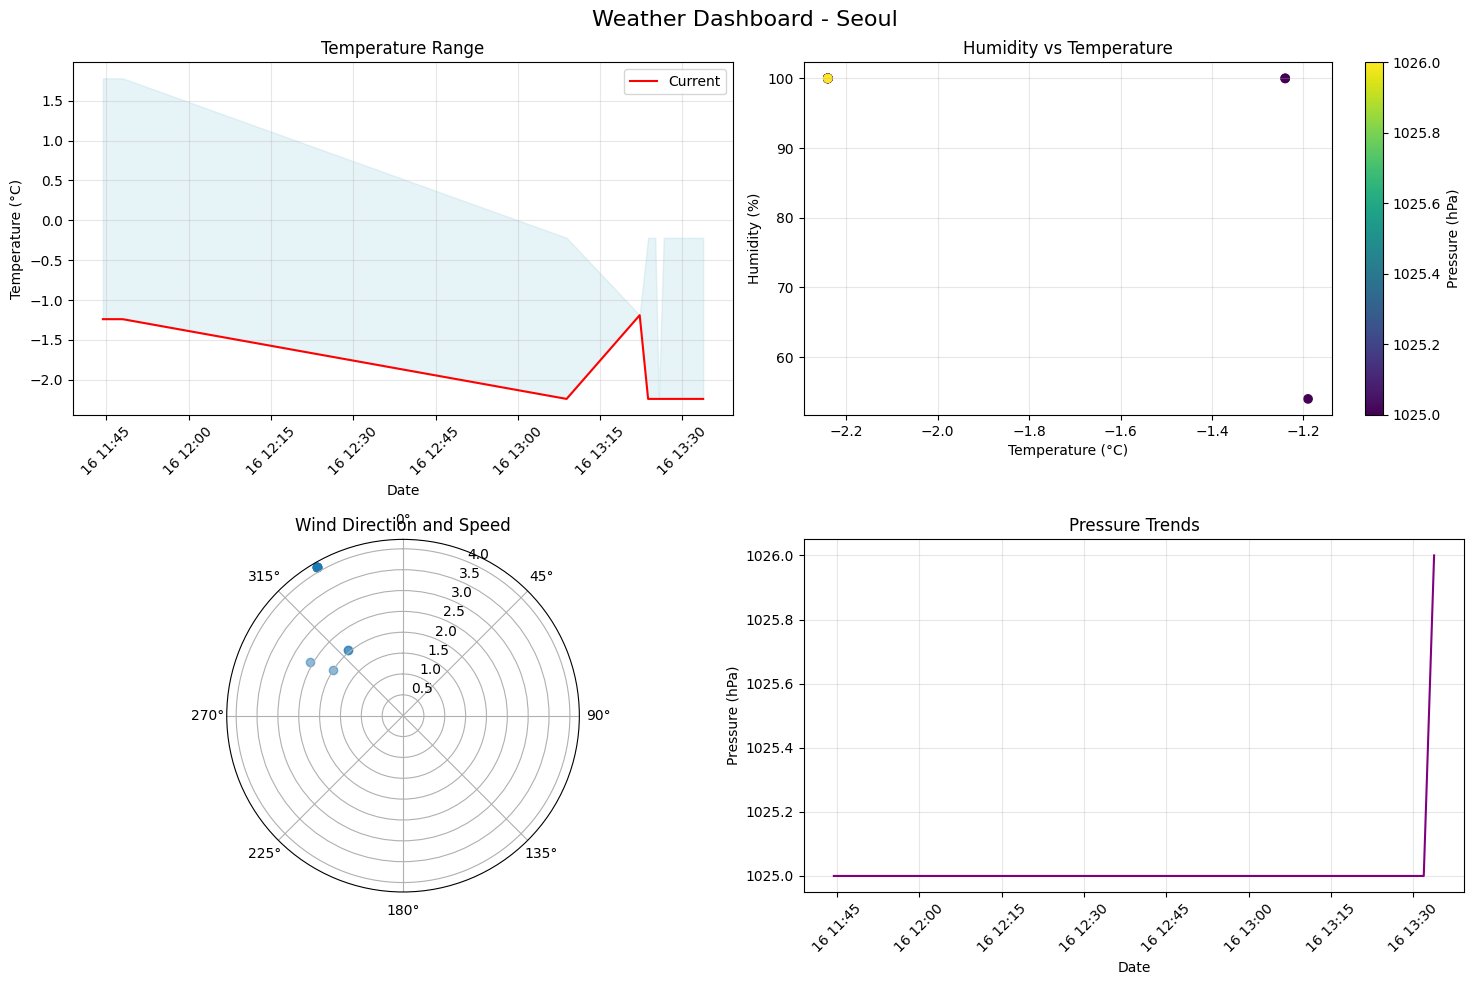

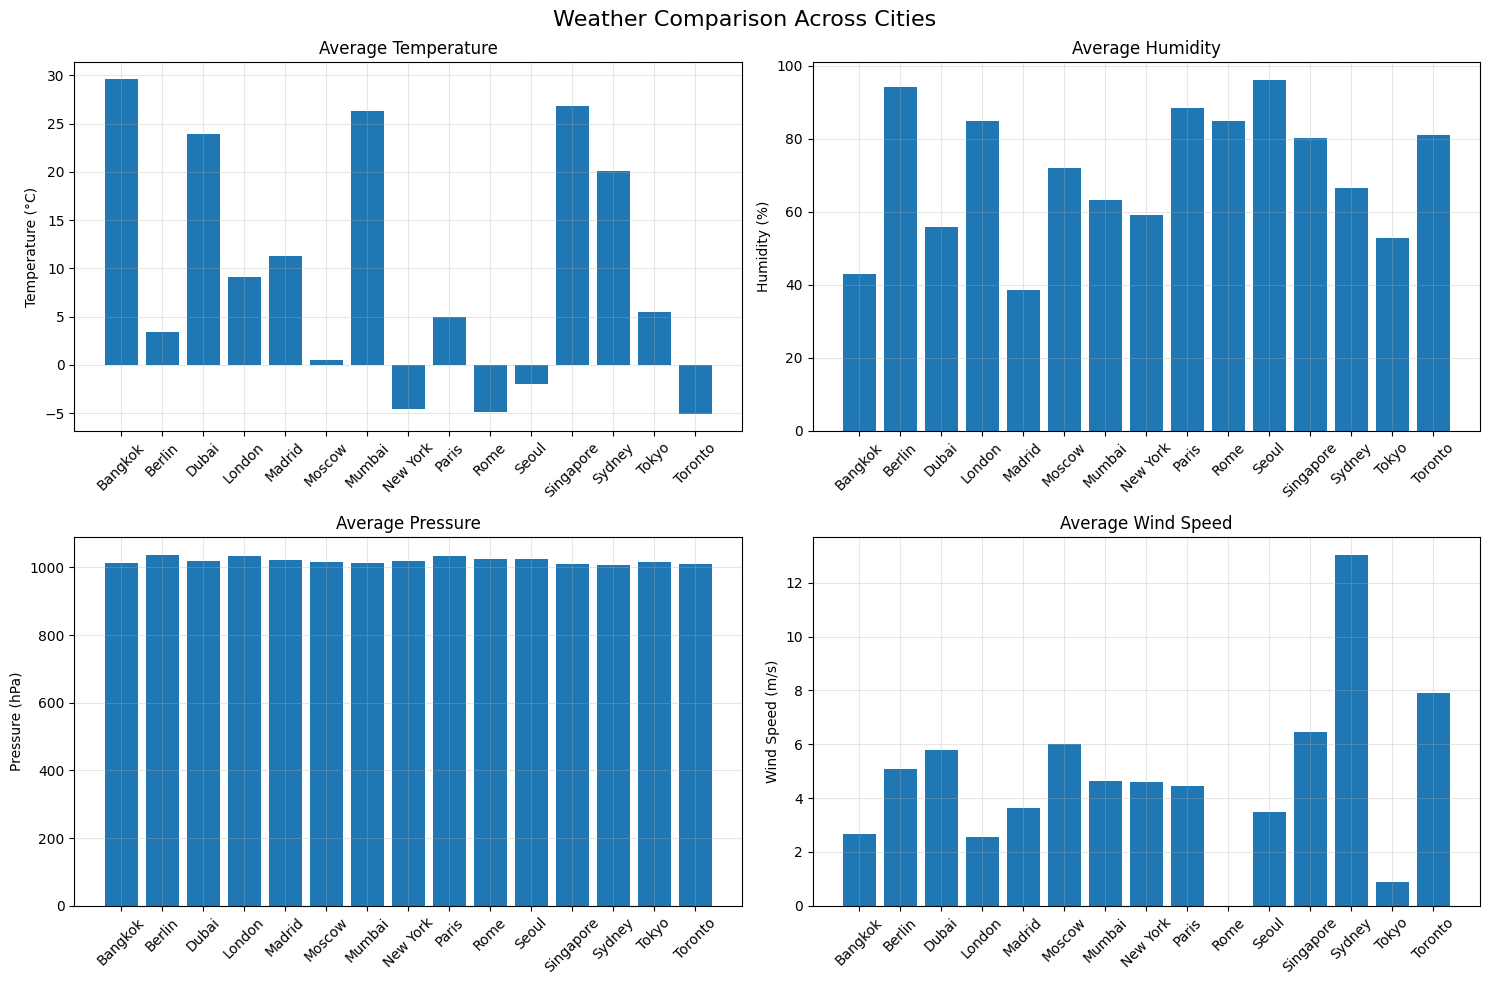

Visualization complete!


In [70]:
if __name__ == "__main__":
    main()